## Import

In [3]:
import requests
from bs4 import BeautifulSoup
import urllib.parse
from selenium import webdriver
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import dataframe_image as dfi
import seaborn as sns

## Getting the data

#### Scraping the list of top 20

In [60]:
headers = {"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36"}
website = 'https://coinmarketcap.com/coins/'
response = requests.get(website, headers=headers)

In [61]:
soup = BeautifulSoup(response.content, "html.parser")

In [62]:
# Need 2 classes, because the first one only gives me the top 10.

classes_to_scrape = ["sc-16r8icm-0 escjiH", "sc-1rqmhtg-0 jUUSMS"]
landing_url = []

In [63]:
for classes in classes_to_scrape:
    result_container = soup.find_all(class_= classes)
    
    for item in result_container:    
        landing_url.append(item.find('a').get('href'))

In [64]:
landing_url = [x + "markets/" for x in landing_url] 

In [65]:
home_page = 'https://coinmarketcap.com/'

In [66]:
# Joining home page with url.
top_20 = []
for link in landing_url[:20]:
    top_20.append(urllib.parse.urljoin(home_page, link))

In [67]:
# Urls of the top 20 coins.

top_20

['https://coinmarketcap.com/currencies/bitcoin/markets/',
 'https://coinmarketcap.com/currencies/ethereum/markets/',
 'https://coinmarketcap.com/currencies/cardano/markets/',
 'https://coinmarketcap.com/currencies/binance-coin/markets/',
 'https://coinmarketcap.com/currencies/xrp/markets/',
 'https://coinmarketcap.com/currencies/solana/markets/',
 'https://coinmarketcap.com/currencies/polkadot-new/markets/',
 'https://coinmarketcap.com/currencies/dogecoin/markets/',
 'https://coinmarketcap.com/currencies/terra-luna/markets/',
 'https://coinmarketcap.com/currencies/avalanche/markets/',
 'https://coinmarketcap.com/currencies/litecoin/markets/',
 'https://coinmarketcap.com/currencies/algorand/markets/',
 'https://coinmarketcap.com/currencies/bitcoin-cash/markets/',
 'https://coinmarketcap.com/currencies/polygon/markets/',
 'https://coinmarketcap.com/currencies/filecoin/markets/',
 'https://coinmarketcap.com/currencies/internet-computer/markets/',
 'https://coinmarketcap.com/currencies/ste

#### Scraping data of the top 20 

In [68]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

In [69]:
wd = webdriver.Chrome('chromedriver',options=options)


In [70]:
# Create empty df.

coinmarket_data = pd.DataFrame(columns=['Source', 'Pairs', 'Price', '+2% Depth', '-2% Depth', 'Volume', 'Volume %', 'Confidence', 'Liquidity', 'Updated'])

In [71]:
# Filling empty df with the scraped data.

for link in top_20:
    wd.get(link)
    html = wd.page_source
    data = pd.read_html(html)
    coinmarket_data = coinmarket_data.append(data[0].loc[0:4, ['Source', 'Pairs', 'Price', '+2% Depth',
                                              '-2% Depth', 'Volume', 'Volume %', 'Confidence',
                                              'Liquidity', 'Updated']], ignore_index=True)

## Data transformation

In [77]:
class DataTransform:
    
    """A class that transforms the scraped data into the desired form."""
    
    def __init__(self, data):
        self.data = data
        
    def rename_cols(self):
        
        # Renames columns as requested.
        
        data = self.data
        data.rename(columns={'Source': 'Exchange', 'Pairs': 'Symbol'}, inplace=True)
        
        return data
    
    def base_quote(self):
        
        # Creates 2 new columns. Base and Quote from Symbol. Then reorders the columns.
        
        data = self.rename_cols()
        data[['Base', 'Quote']] = data['Symbol'].str.split('/', 1, expand=True)
        data = data[['Exchange', 'Symbol', 'Base', 'Quote', 'Price',
                                   '+2% Depth', '-2% Depth', 'Volume', 'Volume %',
                                   'Confidence', 'Liquidity', 'Updated']]
        
        return data
    
    def remove_dollar(self):
        
        # Removes dollar signs and commas.
        
        data = self.base_quote()
        new_data = data.replace({r'\$':''}, regex = True)
        new_data = new_data.replace({r'\,':''}, regex = True)
        
        return new_data
    
    
    def numeric_columns(self):
        
        # Transforms objects to numeric values.
        
        data = self.remove_dollar()
        data["Price"] = pd.to_numeric(data["Price"])
        data["+2% Depth"] = pd.to_numeric(data["+2% Depth"])
        data["-2% Depth"] = pd.to_numeric(data["-2% Depth"])
        data["Volume"] = pd.to_numeric(data["Volume"])
        data["Liquidity"] = pd.to_numeric(data["Liquidity"])
        
        return data

        

In [78]:
# instance of class
coin = DataTransform(coinmarket_data)

In [80]:
coinmarket_data = coin.numeric_columns()

In [81]:
coinmarket_data

,Exchange,Symbol,Base,Quote,Price,+2% Depth,-2% Depth,Volume,Volume %,Confidence,Liquidity,Updated
0,Binance,BTC/USDT,BTC,USDT,55220.40,17848321.99,17410047.50,2855026901,7.52%,High,908.0,Recently
1,Huobi Global,BTC/USDT,BTC,USDT,55226.49,15658416.76,5934895.59,831294350,2.19%,Low,894.0,Recently
2,Coinbase Exchange,BTC/USD,BTC,USD,55253.88,7017759.34,9136913.96,759161286,2.00%,High,891.0,Recently
3,Binance,BTC/BUSD,BTC,BUSD,55190.85,8106881.08,6645407.91,667834880,1.76%,High,859.0,Recently
4,FTX,BTC/USD,BTC,USD,55188.00,21004607.08,27936644.76,612211017,1.61%,Moderate,927.0,Recently
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Binance,ETC/USDT,ETC,USDT,54.41,1526625.09,1208228.47,82132178,9.18%,High,620.0,Recently
96,Huobi Global,ETC/USDT,ETC,USDT,54.41,626513.24,1330777.23,24296892,2.71%,Moderate,434.0,Recently
97,Coinbase Exchange,ETC/USD,ETC,USD,54.38,666116.06,535924.01,12595781,1.41%,High,380.0,Recently
98,Bithumb,ETC/KRW,ETC,KRW,55.56,443068.42,421494.42,10758462,1.20%,High,262.0,Recently


In [206]:
# saving table to csv
coinmarket_data.to_csv(r'top_20_2021-10-07.csv', index=False)

In [4]:
# loading csv to dataframe, so I can use the same data as before 
coinmarket_data = pd.read_csv('top_20_2021-10-07.csv')

## Visualization

In [5]:
class CoinViz:
    
    """A class that creates a table and a stacked barchart visualization for a given coin."""

    def __init__(self, data):
        self.data = data


    def liquidity_table(self,base):
        
        # Creates a table for a coin that summarizes its liquidity
        
        data = self.data
        base_table = data.loc[data['Base'] == base]
        table = base_table[['Symbol', 'Exchange', 'Volume', 'Volume %', '+2% Depth', '-2% Depth']]


        return table
    
    def table_style(self, base, title, save=False):
        
        # Creates a table visualization that can be saved.
        
        data = self.liquidity_table(base)
        data = data.style.format({'Volume': "{:.2E}".format,
                   '+2% Depth': "{:.2E}".format,
                   '-2% Depth': "{:.2E}".format}).hide_index().set_caption(title)
        
        if save == True:
            
            dfi.export(data, str(title) + ".png")
            
        else:
            return data
        
    def bar_chart_data(self, base):
        
        # Creates a dataframe suitable for bar charts.
        
        data = self.data
        base_table = data.loc[(data['Base'] == base) & (data['Quote'].isin(["USD", "USDT"]))]
        table = base_table[['Quote','Exchange', 'Volume']]
    
    
        return table
        
    
    def liquidity_bar_chart(self, base, title, save=False):
        
        # Creates a bar chart of the volume for a given coin.
        
        data = self.bar_chart_data(base)
        data.groupby(["Quote", "Exchange"])["Volume"].sum().unstack().plot(kind='bar', stacked=True, title=title,
                                                                 ylabel='Volume', figsize=(8,8))

        plt.xticks(rotation=0, ha='center')
        matplotlib.style.use('seaborn-darkgrid')
        
        if save == True:
            plt.savefig(str(title) + ".png")
            plt.show()
            
        else:
            plt.show()
    

In [6]:
# Creating instance of class

coinmarket= CoinViz(coinmarket_data)

In [8]:
# List of coins

coins = coinmarket_data['Base'].unique()

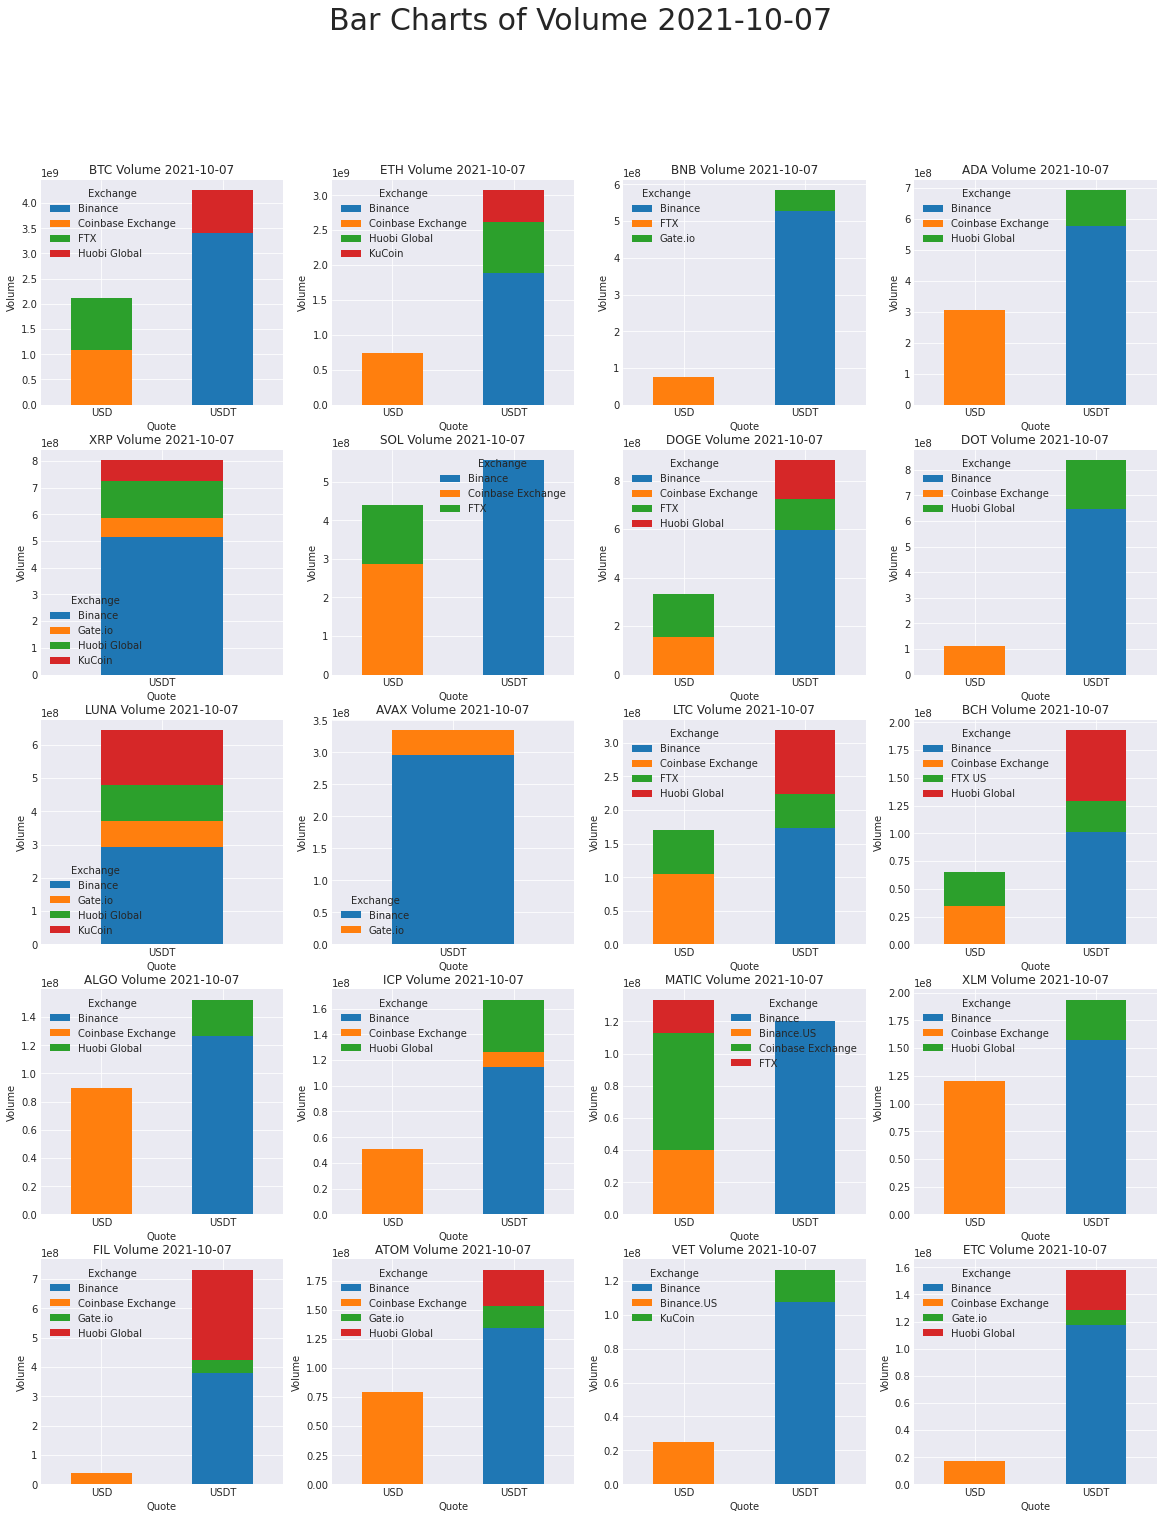

In [24]:
# Subplotting bar charts

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,24))
fig.suptitle("Bar Charts of Volume 2021-10-07", fontsize=30)

for ax, yvar in zip(axes.flat, coins):
    data = coinmarket.bar_chart_data(yvar)
    data.groupby(["Quote", "Exchange"])["Volume"].sum().unstack().plot(kind='bar', stacked=True,
                                                                       title=str(yvar) + " Volume 2021-10-07",
                                                                       ylabel='Volume', ax=ax)
    ax.tick_params(labelrotation=0)
matplotlib.style.use('seaborn-darkgrid')

## Required files

In [84]:
# 1 table of BTC

coinmarket.table_style('BTC', 'BTC Top 5 Volume 2021-10-08')

Symbol,Exchange,Volume,Volume %,+2% Depth,-2% Depth
BTC/USDT,Binance,2.86E+09,7.52%,1.78E+07,1.74E+07
BTC/USDT,Huobi Global,8.31E+08,2.19%,1.57E+07,5.93E+06
BTC/USD,Coinbase Exchange,7.59E+08,2.00%,7.02E+06,9.14E+06
BTC/BUSD,Binance,6.68E+08,1.76%,8.11E+06,6.65E+06
BTC/USD,FTX,6.12E+08,1.61%,2.10E+07,2.79E+07


In [50]:
# 20 bar charts of all assets

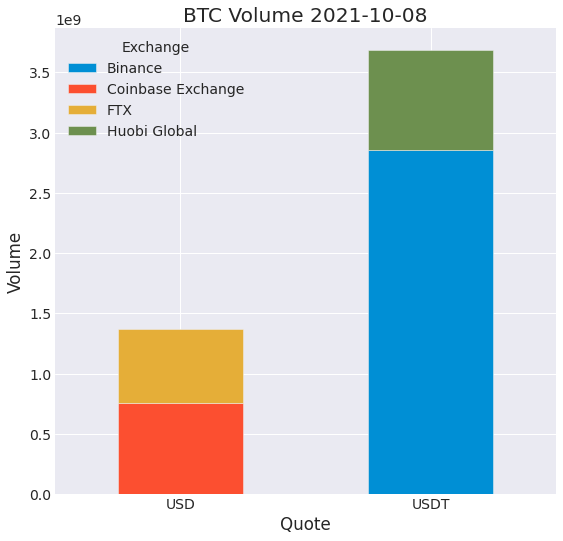

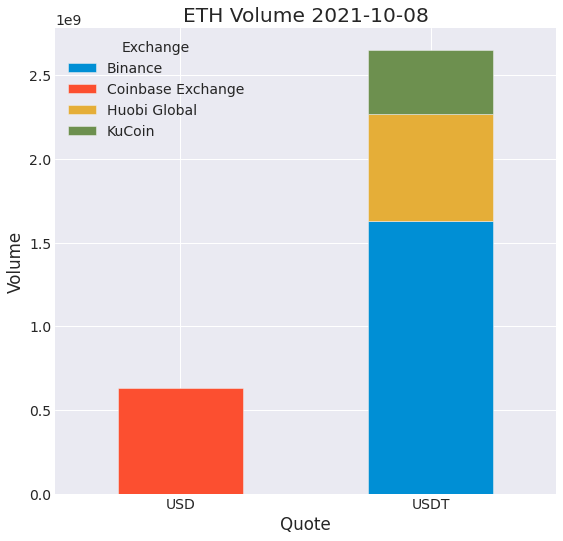

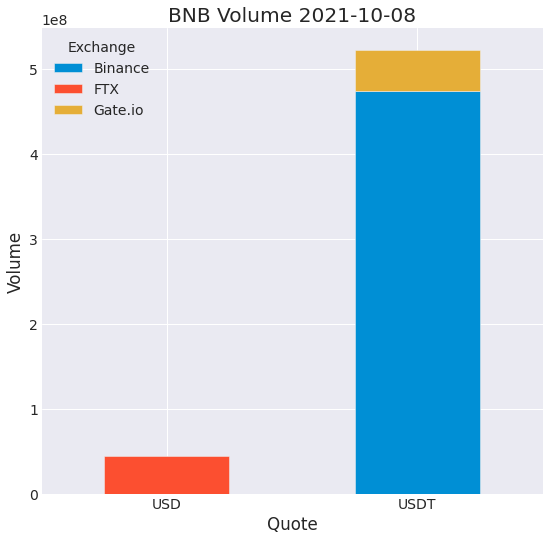

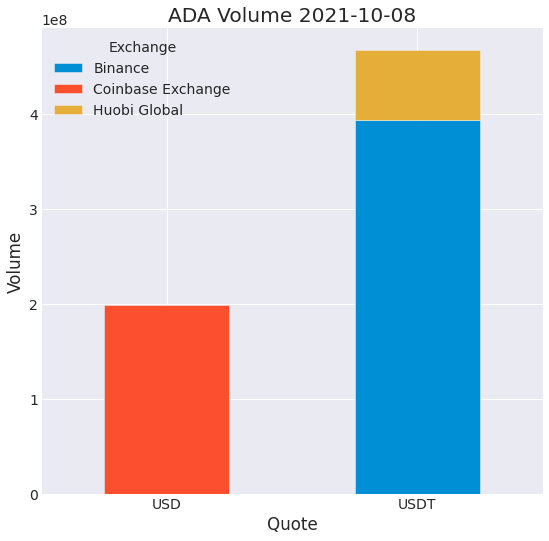

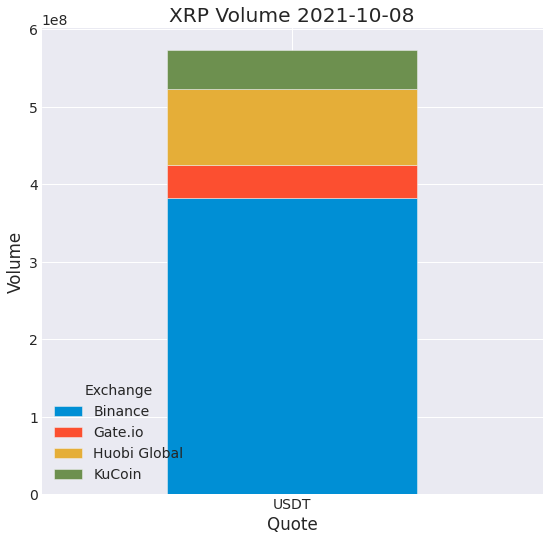

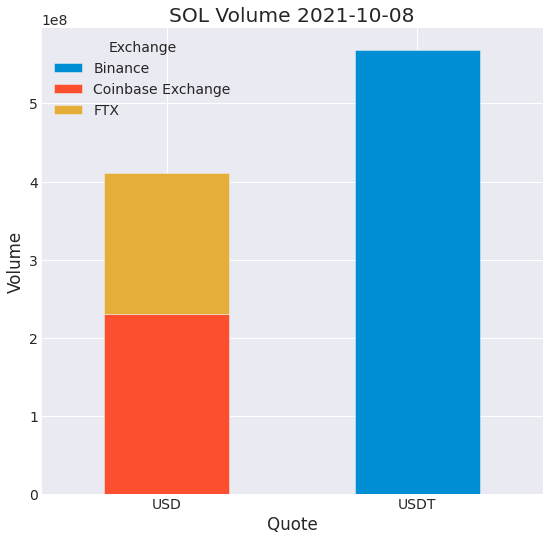

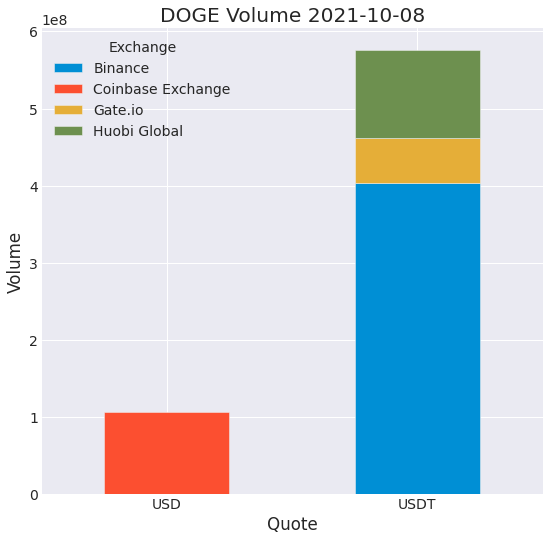

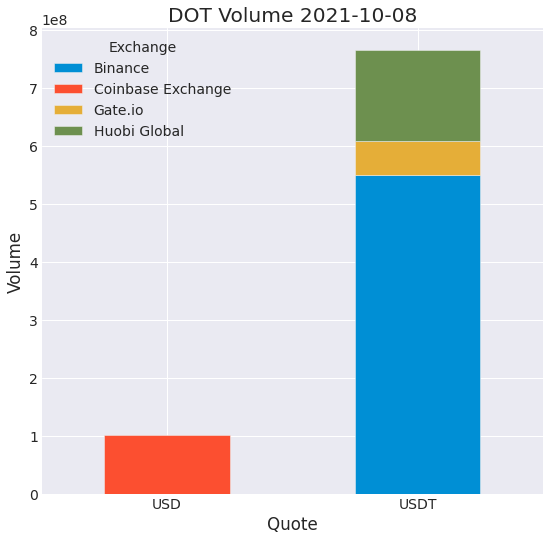

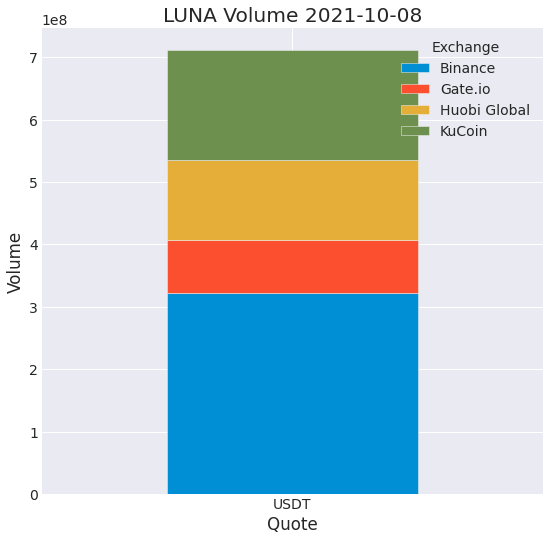

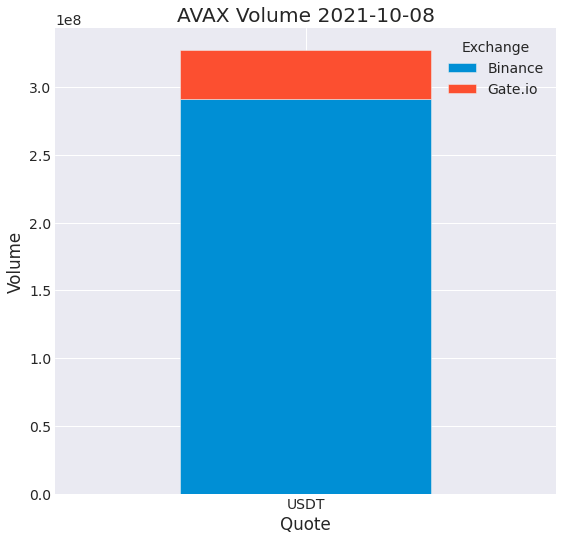

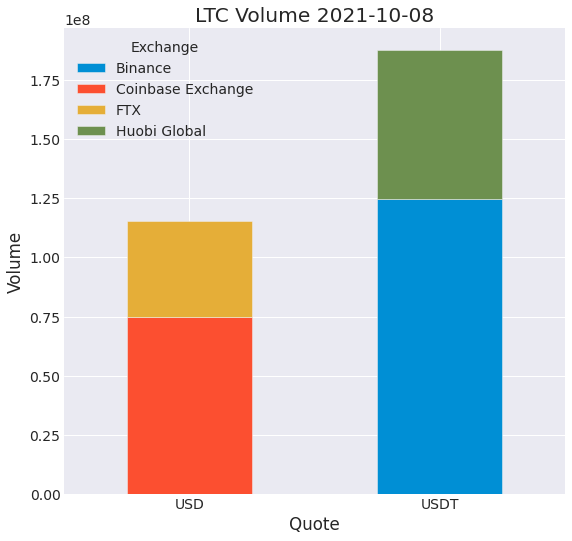

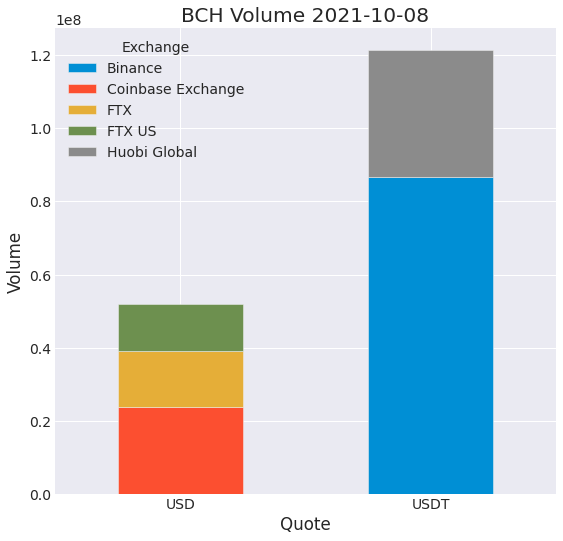

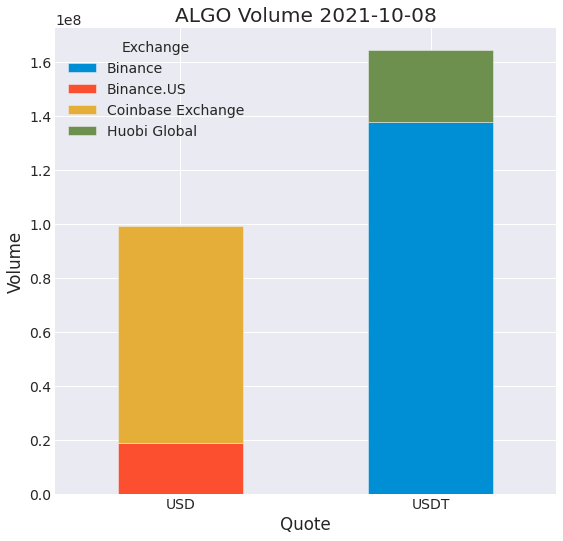

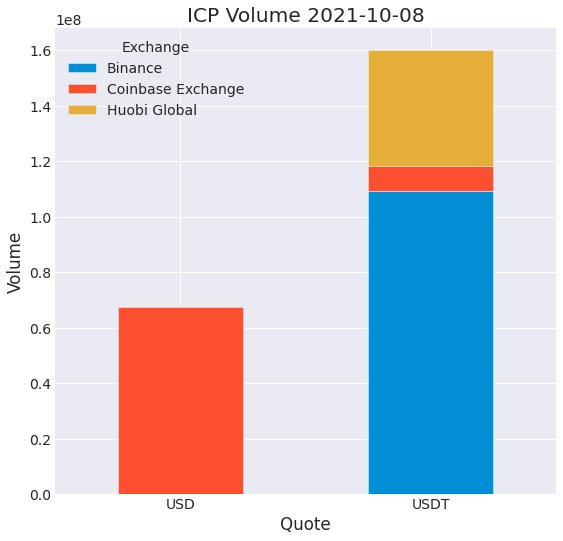

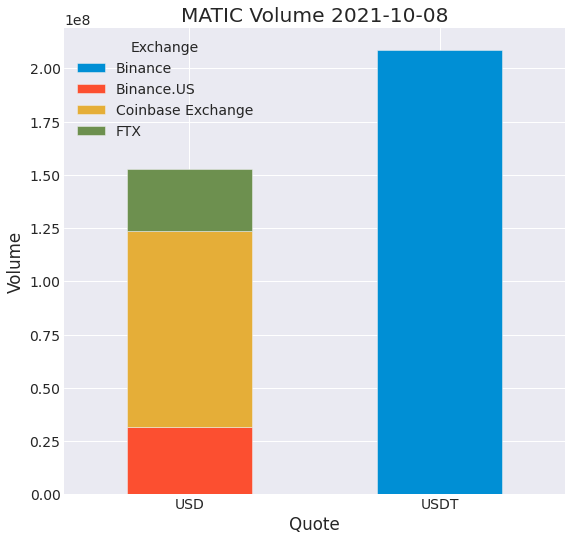

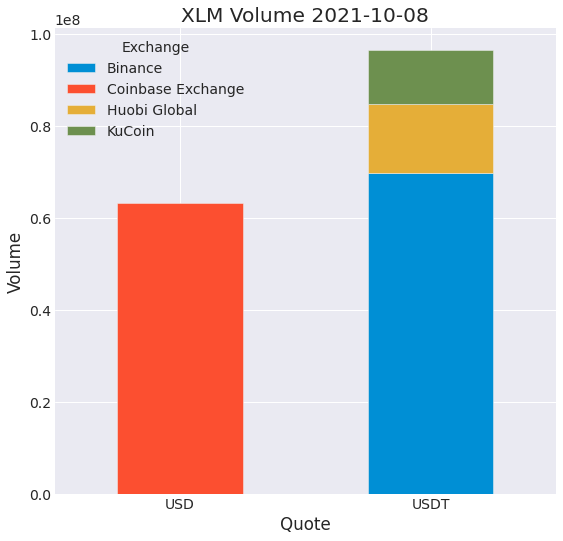

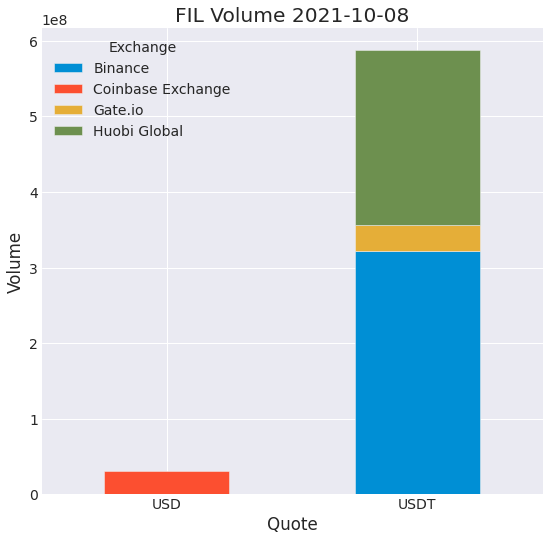

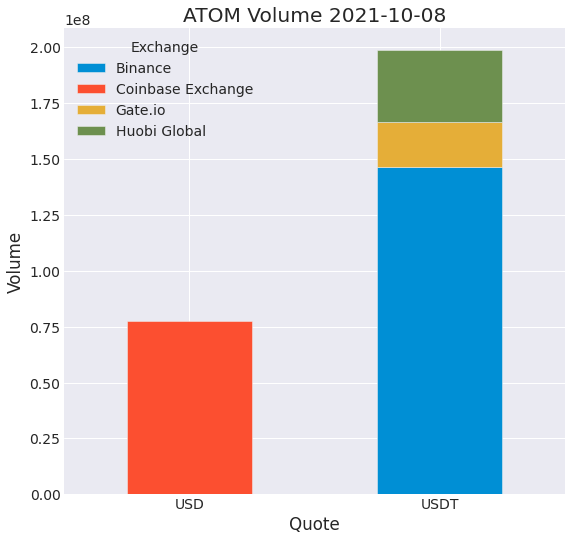

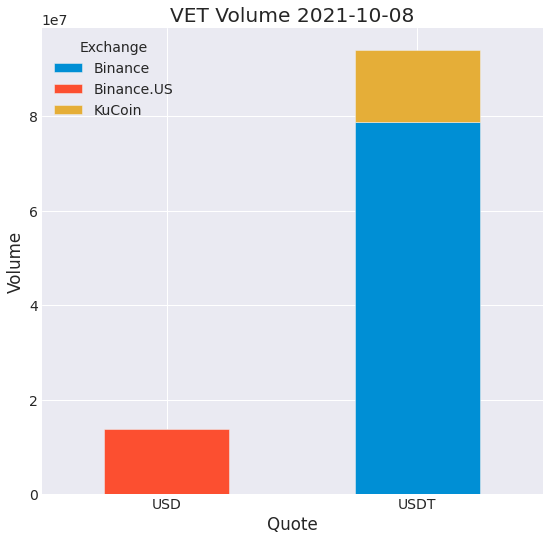

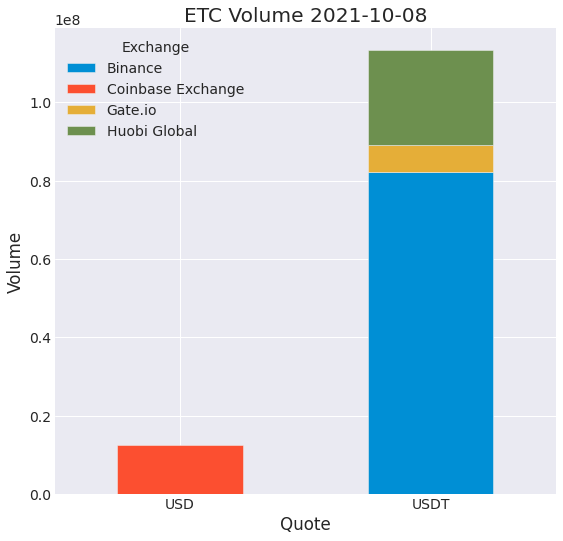

In [86]:
for coin in coins:
    title = str(coin) + " Volume 2021-10-08"
    
    coinmarket.liquidity_bar_chart(coin, title)